In [ ]:
import numpy as np
from numpy.random import choice

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F

import math

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from scipy.integrate import odeint

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install cmasher
import cmasher as cmr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 5.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Burgers_data_np = np.load("/content/drive/MyDrive/Burgers_eq_data.pth.npy")

Burgers_data = torch.from_numpy(Burgers_data_np).type(torch.float32).to(device)

In [ ]:
# Generate training data

# Num of training samples
num_samples = 3000

np.random.seed(1)

# Spatial mesh
L_x = 1
dx = 0.005
N_x = int(L_x/dx + 1)
X = np.linspace(0,L_x,N_x)

# Temporal mesh
L_t = 1.0
dt = 0.005
N_t = int(L_t/dt + 1)
T = np.linspace(0,L_t,N_t)

k = 2*np.pi*np.fft.fftfreq(N_x, d = dx)

# Datasets for training
phi = torch.zeros(size=(N_x*num_samples,N_x))
v = torch.zeros(size=(N_x*num_samples,N_x))
t = torch.zeros(size=(N_x*num_samples,1))

# Dataset used to store entire numerical solutions
Phi = np.zeros(shape=(num_samples,N_x,N_t))

# Data loop
for num in range(num_samples):


  # Random coefficients
  alpha = np.random.uniform(-1,1,6)
  phi_0 = alpha[0]*np.cos(2*math.pi*X) + alpha[1]*(np.cos(2*math.pi*X))**3 + alpha[2]*(np.cos(2*math.pi*X))**5

  def burg_system(u,t,k):
    mu = 1
    nu = 0.01
    u_hat = np.fft.fft(u)
    u_hat_x = 1j*k*u_hat
    u_hat_xx = -k**2*u_hat
    u_x = np.fft.ifft(u_hat_x)
    u_xx = np.fft.ifft(u_hat_xx)
    u_t = -mu*u*u_x + nu*u_xx
    return u_t.real


  #phi_i = odeint(burg_system, phi_0, T, args=(k,), mxstep=5000).T

  phi_i = Burgers_data_np[num,:,:]

 # Phi[num,:,:] = phi_i

  time_indices = np.random.randint(0, T.size, N_x) #np.random.randint(0, 99, N_x) #np.random.randint(0, T.size, N_x)
  time_indices = np.arange(N_t)

  # Store data from Phi into suitable tensors for training.
  # These tensors are organized by (i) initial condition, (ii) later time for solution, (iii) later solution
  phi[num*N_x:(num+1)*N_x,0:N_x] = torch.from_numpy(phi_i[:,0])
  t[num*N_x:(num+1)*N_x,0] = torch.from_numpy(T[time_indices])
  v[num*N_x:(num+1)*N_x,0:N_x] = torch.from_numpy(np.transpose(phi_i[:,time_indices]))

  if num % 1000 == 0:
    print(num)

0
1000
2000


In [ ]:
File = "Burgers_geo_flow_data.pth"
np.save(File, Phi)

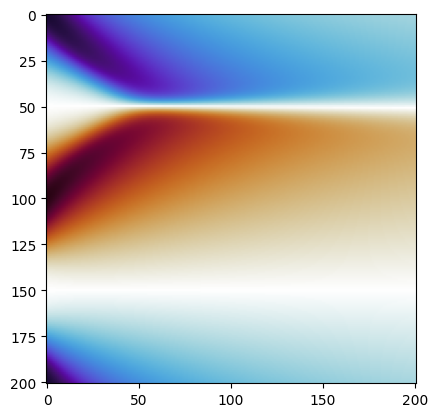

In [ ]:
plt.imshow(phi_i, cmap=cmr.fusion)

In [ ]:
# Initialize data with PyTorch for training

Phi = phi.type(torch.float32).to(device).requires_grad_()
V = v.type(torch.float32).to(device).requires_grad_()
times = t.type(torch.float32).to(device).requires_grad_()

In [ ]:
# Randomly sampled times
times_unif = np.random.uniform(0,1.0,size=(Phi.size(dim=0),1))
times_unif[0:num_samples] = 0
times_unif = torch.tensor(times_unif, requires_grad=True).type(torch.float32).to(device)

In [ ]:
w = 200
N_x = 201 # input width

# It is necessary that intrinsic dim = 2 because that is how Gaussian curvature is defined
intrinsic_dim = 2
extrinsic_dim = 3

class parameterization_NN(nn.Module):
    def __init__(self):
        super(parameterization_NN, self).__init__()
        self.x_layer1 = nn.Linear(N_x,w,bias=True); self.x_layer2 = nn.Linear(w,w, bias=True); self.x_layer3 = nn.Linear(w,w, bias=True)
        self.x_mean_1 = nn.Linear(w,w, bias=True); self.x_mean_2 = nn.Linear(w,intrinsic_dim, bias=True)
        self.x_std_1 = nn.Linear(w,w, bias=True); self.x_std_2 = nn.Linear(w,intrinsic_dim, bias=True)

    def forward(self, u):
        inputs = u
        x1_out = F.tanh(self.x_layer1(inputs)); x2_out = F.tanh(self.x_layer2(x1_out)); x3_out = F.tanh(self.x_layer3(x2_out))
        x_mean_1 = F.tanh(self.x_mean_1(x3_out)); x_mean_2 = self.x_mean_2(x_mean_1)
        x_std_1 = F.tanh(self.x_std_1(x3_out)); x_std_2 = self.x_std_2(x_std_1)
        return x_mean_2, x_std_2

In [ ]:
class g_NN(nn.Module):
    def __init__(self):
        super(g_NN, self).__init__()
        self.intrinsic_dim = intrinsic_dim

        self.x_layer1 = nn.Linear(intrinsic_dim + 1, w, bias=True)
        self.x_layer2 = nn.Linear(w, w, bias=True)
        self.x_layer3 = nn.Linear(w, w, bias=True)
        self.x_layer4 = nn.Linear(w, intrinsic_dim**2, bias=True)



    def forward(self, uv, tau):
        u = torch.cat((uv, tau), dim=1)
        x1_out = F.gelu(self.x_layer1(u))
        x2_out = F.gelu(self.x_layer2(x1_out))
        x3_out = F.gelu(self.x_layer3(x2_out))
        x4_out = self.x_layer4(x3_out)

        output_A = torch.reshape(x4_out, (u.size(0), self.intrinsic_dim, self.intrinsic_dim))
        g = torch.bmm(output_A.transpose(1, 2), output_A)

        diag_indices = torch.arange(self.intrinsic_dim, device=g.device)
        diag = g[:, diag_indices, diag_indices]
        g[:, diag_indices, diag_indices] = diag

        i, j = torch.triu_indices(self.intrinsic_dim, self.intrinsic_dim, offset=1)
        off_diag = g[:, i, j]
        g[:, i, j] = off_diag
        g[:, j, i] = off_diag

        return g

In [ ]:
class encoder_NN(nn.Module):
    def __init__(self):
        super(encoder_NN, self).__init__()
        self.x_layer1 = nn.Linear(intrinsic_dim+1,w,bias=True); self.x_layer2 = nn.Linear(w,w, bias=True)
        self.x_layer3 = nn.Linear(w,w, bias=True); self.x_layer4 = nn.Linear(w,extrinsic_dim, bias=True)

    def forward(self, uv, tau):
        inputs = torch.cat((uv, tau),1)
        x1_out = F.tanh(self.x_layer1(inputs))
        x2_out = F.tanh(self.x_layer2(x1_out))
        x3_out = F.tanh(self.x_layer3(x2_out))
        x4_out = self.x_layer4(x3_out)
        return x4_out

In [ ]:
class decoder_NN(nn.Module):
    def __init__(self):
        super(decoder_NN, self).__init__()
        self.x_layer1 = nn.Linear(extrinsic_dim,w,bias=True); self.x_layer2 = nn.Linear(w,w, bias=True)
        self.x_layer3 = nn.Linear(w,w, bias=True); self.x_layer4 = nn.Linear(w,N_x, bias=True)

    def forward(self, u):
        x1_out = F.tanh(self.x_layer1(u))
        x2_out = F.tanh(self.x_layer2(x1_out))
        x3_out = F.tanh(self.x_layer3(x2_out))
        x4_out = self.x_layer4(x3_out)
        return x4_out

In [ ]:
# Create neural networks
parameterization = parameterization_NN().to(device) # local coordinates
g = g_NN().to(device) # Riemannian metric
encoder = encoder_NN().to(device) # from sphere manifold to learned manifold
decoder = decoder_NN().to(device) # decoder to PDE data

In [ ]:
optimizer = optim.Adam([
    {'params': parameterization.parameters()},
    {'params': g.parameters()},
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
], lr=2e-4)

In [ ]:
parameterization.load_state_dict(torch.load("parameterization.pth"))
g.load_state_dict(torch.load("g.pth"))
encoder.load_state_dict(torch.load("encoder.pth"))
decoder.load_state_dict(torch.load("decoder.pth"))

<All keys matched successfully>

In [ ]:
# Reparameterization trick
def get_reparameterization_sample(parameterization, U, intrinsic_dim, N):
  means_eval, stds_eval = parameterization(U)

  random_normal = torch.normal(0,1,size=(N,intrinsic_dim), requires_grad=True).to(device)

  uv_sample = means_eval  +   stds_eval * random_normal

  return uv_sample

In [ ]:
# Create function to get metric coefficients of the encoder neural network (not g)
def induced_metric_func(encoder, uv, tau, intrinsic_dim, extrinsic_dim, N):

  encoder_uv = torch.zeros(size=(N,extrinsic_dim,intrinsic_dim)).to(device)
  encoded_rep = encoder(uv, tau)
  for col in range(encoder_uv.size(dim=1)):
    encoder_uv[:,col,:] = torch.autograd.grad(encoded_rep[:,col].sum(), uv, create_graph=True)[0]

  encoder_metric = torch.zeros(size=(N,intrinsic_dim,intrinsic_dim)).to(device)

  for i in range(intrinsic_dim):
    for j in range(i+1):
      encoder_metric[:,i,j] = torch.sum( torch.squeeze(encoder_uv[:,:,i]) * torch.squeeze(encoder_uv[:,:,j]), dim=1)
      encoder_metric[:,j,i] = encoder_metric[:,i,j]

  return encoder_metric

In [ ]:
# Compute inverse of metric
def g_inv(G):
  G_inv = torch.linalg.pinv(G).to(device)
  return G_inv

In [ ]:
def loss_decoded_func(Phi_t, uv, tau, encoder, decoder, parameterization, N):

  encoded_rep = encoder(uv, tau)
  decoded_rep = decoder(encoded_rep)

  diff = decoded_rep - Phi_t
  loss = (1/torch.numel(diff)) * torch.norm(diff)**2

  return loss

In [ ]:
# KL divergence regularization with a Gaussian prior
def loss_kl_func_uv(parameterization, U, N):

  means_eval, stds_eval = parameterization(U)
  epsilon = 1e-18

  kl_loss =  -torch.sum(1 + torch.log(stds_eval**2 + epsilon) - means_eval**2 - stds_eval**2, dim=1)

  return torch.mean(kl_loss)

In [ ]:
# Create loss function between the metric neural network and the computed metric with the encoder
def loss_metric_func(g, encoder, uv, tau, intrinsic_dim, N):

  g_rep = g(uv, tau)
  inner_product_matrix = induced_metric_func(encoder, uv, tau, intrinsic_dim, extrinsic_dim, N)
  diff =  g_rep  - inner_product_matrix

  # Return loss, which is a scaled matrix norm
  loss = (1/torch.numel(diff))*torch.norm(diff)**2
  return loss

In [ ]:
# Get partial derivative of metric
def get_partials_g(G, uv, N, disc_length):
  partials_g = torch.zeros(size=(intrinsic_dim,intrinsic_dim,N*disc_length,intrinsic_dim)).to(device)
  for i in range(2):
    for j in range(2):
      partial_g_ij = torch.autograd.grad(G[:,i,j].sum(), uv, create_graph=True)[0][:,:]
      partials_g[i,j,:,:] = partial_g_ij
  return partials_g

In [ ]:
# Get Christoffel symbols
def get_Christoffel_symbols(partials_g, G_inv, intrinsic_dim, N, disk_length):
  Gamma = torch.zeros(size=(N*disk_length,intrinsic_dim,intrinsic_dim,intrinsic_dim)).to(device)
  for l in [1]:
    for i in [0]:
      for j in range(2):
        Gamma_l_ij = 0
        for k in range(2):
          partial_j_g_ik = partials_g[i,k,:,j]
          partial_k_g_ij = partials_g[i,j,:,k]
          partial_i_g_kj = partials_g[k,j,:,i]

          Gamma_l_ij = Gamma_l_ij + (1/2) * (G_inv[:,k,l]) * (partial_j_g_ik - partial_k_g_ij + partial_i_g_kj)

        Gamma[:,l,i,j] = Gamma_l_ij


  return Gamma

In [ ]:
# Sample a circle in U before psi map
def sample_circle_in_U_func(uv, intrinsic_dim, N, disk_length, radius):

    # Initialize circles with centers and angles
    centers = uv
    theta = torch.linspace(0, 2 * torch.pi, disk_length).to(device)
    circle_2d = torch.stack([radius * torch.cos(theta), radius * torch.sin(theta)], dim=1)

    circle = torch.zeros((disk_length, intrinsic_dim)).to(device)
    circle[:, :2] = circle_2d

    circles = centers[:, None, :] + circle[None, :, :]
    return circles, theta

In [ ]:
# Path integral loss
def path_integral_loss(uv, tau, intrinsic_dim, N, disk_length, radius):

  # Sample circle and map with psi
  uv_circle, circle_polar = sample_circle_in_U_func(uv, intrinsic_dim, N, disk_length, radius)
  uv_circle_ = uv_circle.reshape(N*disk_length, intrinsic_dim)

  # Tensor for times but repeated
  tau_extended = tau.repeat_interleave(disk_length, dim=0).requires_grad_()



  # Get g and relevant components after psi map
  g_eval = g(uv_circle_, tau_extended)
  g_inv_eval = g_inv(g_eval)
  g_partials = get_partials_g(g_eval, uv_circle_, N, disk_length)
  Christoffel_symbols = get_Christoffel_symbols(g_partials, g_inv_eval, intrinsic_dim, N, disk_length)
  det_g = torch.linalg.det(g_eval)

  # Extended angles
  theta_extended = circle_polar.repeat_interleave(N, dim=0).requires_grad_()

  # Closed line integral loss
  path_integral =  2 * ((torch.abs(det_g)**(1/2)) / (torch.abs(g_eval[:,0,0]) + 1e-18)) * ( radius * Christoffel_symbols[:,1,0,0] * (- torch.sin(theta_extended))  \
                                               + radius * Christoffel_symbols[:,1,0,1] * (torch.cos(theta_extended))   )


  # Gaussian curvature surrogate with the average
  Gauss_curv_surrogate = path_integral.view(N, disk_length, 1).sum(dim=1) / disk_length


  loss = torch.mean(path_integral)

  return loss, Gauss_curv_surrogate



In [ ]:
# Compute remaining part of flow not due to line integration
def loss_flow_func(g, uv, tau, Gauss_curv, N, disk_length, radius):

  # Sample circle and map with psi


  # Extend times and Gaussian curvature
  tau_extended = tau.repeat_interleave(disk_length, dim=0).requires_grad_()
  K_extended = Gauss_curv.repeat_interleave(disk_length, dim=0)

  # Evaluate g
  g_eval = g(uv, tau_extended)


  # Time derivative of g
  g_t = torch.zeros(size=(N*disk_length,intrinsic_dim,intrinsic_dim), requires_grad=True).to(device)
  for row in range(intrinsic_dim):
    for col in range(row+1):
      g_t[:,row,col] = torch.autograd.grad(g_eval[:,row,col].sum(), tau_extended, create_graph=True)[0][:,0]
      g_t[:,col,row] = g_t[:,row,col]

  g_t = 0.5 * (g_t + g_t.transpose(-1, -2))

  det_g = torch.linalg.det(g_eval)


  denominator =   g_eval * g_t - 2 * K_extended.view(N*disk_length, 1, 1) * g_eval**2




  # Remaining part of flow
  geo_flow = (torch.abs(det_g.view(N * disk_length,1,1))**(1/2) ) * ( g_t**2 -  (g_eval**2) * (K_extended**2).view(N * disk_length,1,1)  ) \
             / (denominator.view(N*disk_length, 2, 2) + 1e-18)




  loss =  torch.mean(geo_flow)

  return loss


In [ ]:
index = 0
g_metric_iter = torch.zeros(size=(10000,intrinsic_dim,intrinsic_dim)).to(device)

In [ ]:
# Training algorithm

num_iter = 100

# Large batch size works well
N = 800


import time
start = time.time()


for num in range(num_iter):

  I = np.random.randint(0,int(num_samples*N_x),N)

  means, stds = parameterization(Phi[I,:])
  uv = get_reparameterization_sample(parameterization, Phi[I,:], intrinsic_dim, N)
  tau = times[I,:]
  tau_unif = times_unif[I,:]

  # Hyperparameters of each sampled closed line integral
  radius = 0.15
  disk_length = 6


  # Compute all loss terms
  loss_kl = loss_kl_func_uv(parameterization, Phi[I,:], N)
  loss_decoded = loss_decoded_func(V[I,:], uv, tau, encoder, decoder, parameterization, N)
  loss_K, K_surrogate = path_integral_loss(uv, tau, intrinsic_dim, N, disk_length, radius)
  loss_metric = loss_metric_func(g, encoder, uv, tau, intrinsic_dim, N)
  loss_flow = loss_flow_func(g, uv, tau, K_surrogate, N, disk_length, radius)

  loss_geo_flow = loss_flow - loss_K


  loss =   1000 * loss_decoded  +   0.001 * loss_kl    + 1*loss_metric + 1*loss_geo_flow


  optimizer.zero_grad()
  loss.backward()

  torch.nn.utils.clip_grad_value_(parameterization.parameters(), 1.)
  torch.nn.utils.clip_grad_value_(g.parameters(), 1.)
  torch.nn.utils.clip_grad_value_(encoder.parameters(), 1.)
  torch.nn.utils.clip_grad_value_(decoder.parameters(), 1.)

  optimizer.step()


  if num % 20 == 0:
    index += 1
    g_eval = g(uv, tau)
    g_metric_iter[index,:,:] = torch.mean(g_eval.squeeze().clone(), dim=0)
    print("Training loss:", '{:.4e}'.format(loss.data), \
          "Decoded:", '{:.4e}'.format(loss_decoded.data), \
          "Metric:", '{:.4e}'.format(loss_metric.data), \
          "KL:", '{:.4e}'.format(loss_kl.data), \
          "Geo flow:", '{:.4e}'.format(loss_geo_flow.data))


end = time.time()
print(f"Elapsed time: {end - start:.6f} seconds")

Training loss: 2.7746e+00 Decoded: 2.6686e-03 Metric: 4.3024e-02 KL: 4.1405e+01 Geo flow: 2.1529e-02
Training loss: 2.0299e+00 Decoded: 1.9238e-03 Metric: 4.4441e-02 KL: 4.4760e+01 Geo flow: 1.6909e-02
Training loss: 2.7492e+00 Decoded: 2.6509e-03 Metric: 3.5222e-02 KL: 4.5671e+01 Geo flow: 1.7374e-02
Training loss: 2.4589e+00 Decoded: 2.3576e-03 Metric: 3.5666e-02 KL: 4.6713e+01 Geo flow: 1.8904e-02
Training loss: 2.0066e+00 Decoded: 1.9063e-03 Metric: 3.4319e-02 KL: 4.4366e+01 Geo flow: 2.1670e-02
Elapsed time: 10.114680 seconds


In [ ]:
# Save newly-trained neural networks to current directory

File = "parameterization.pth"
torch.save(parameterization.state_dict(), File)

File = "g.pth"
torch.save(g.state_dict(), File)

File = "encoder.pth"
torch.save(encoder.state_dict(), File)

File = "decoder.pth"
torch.save(decoder.state_dict(), File)

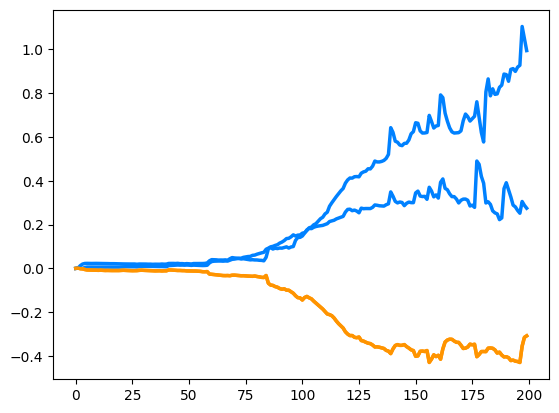

In [ ]:
# Riemannian metric means

Num = 200

colors = plt.cm.jet(np.linspace(0, 1, 5))  # 5 distinct colors from the colormap

for i in range(2):
    plt.plot(g_metric_iter[0:Num, i, i].cpu().detach().numpy(), linewidth=2.5, color=colors[1])
    plt.plot(g_metric_iter[0:Num, 0, 1].cpu().detach().numpy(), linewidth=2.5, color=colors[3])

#plt.xticks(ticks=[0,Num])
#plt.yticks(ticks=[0,0.6,1.2])

plt.savefig('metric.png', dpi=300)

In [ ]:
# Inference testing

np.random.seed(21)

phi_test = torch.zeros(size=(1,N_x,N_t)).to(device)
alpha = np.random.uniform(-1,1,6)
phi_0 = alpha[0]*np.cos(2*math.pi*X) + alpha[1]*(np.cos(2*math.pi*X))**3 + alpha[2]*(np.cos(2*math.pi*X))**5  \
        #   + alpha[3]*np.sin(2*math.pi*X) + alpha[4]*(np.sin(2*math.pi*X))**3 + alpha[5]*(np.sin(2*math.pi*X))**5


phi_i_test = odeint(burg_system, phi_0, T, args=(k,), mxstep=5000).T
phi_test[0,:,:] = torch.from_numpy(phi_i_test).to(device)


phi_test_noise = phi_test.clone()
noise = np.random.normal(0,1.5, size=(201))
noise[np.random.choice(201,100, replace=False)] = 0
phi_test_noise[0,:,0] = 1.0*phi_test[0,:,0].clone()   +   torch.from_numpy(noise).to(device)

In [ ]:
decoded_2d = torch.zeros(size=(N_x,N_t))

for num in range(N_t):
  t_test = (num/(N_t))*torch.ones(size=(1,1)).to(device)
  t_index = int(t_test*100)

  means_eval, stds_eval = parameterization(phi_test_noise[0,:,0])
  random_normal = torch.normal(0,1,size=(1,intrinsic_dim), requires_grad=True).to(device)
  uv_sample = means_eval


  encoded_rep = encoder(uv_sample.unsqueeze(0), t_test)
  decoded_rep = decoder(encoded_rep)

  decoded_2d[:,num] = decoded_rep

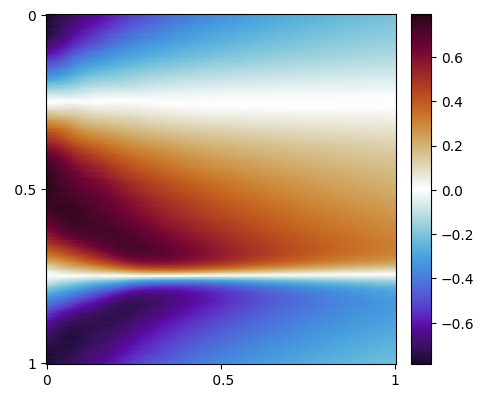

In [ ]:
heatmap2d(decoded_2d.cpu().detach().numpy())

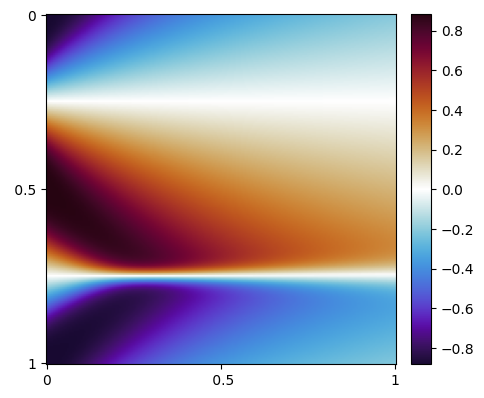

In [ ]:
heatmap2d(phi_test[0,:,:].cpu().detach().numpy())

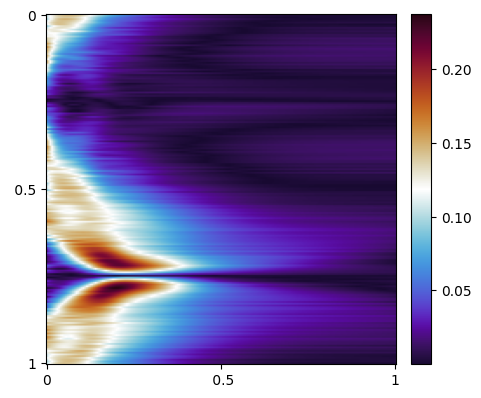

In [ ]:
heatmap2d( np.abs( decoded_2d.cpu().detach().numpy() - phi_test[0,:,:].cpu().detach().numpy() ) )

In [ ]:
print( np.sum(np.abs( decoded_2d.cpu().detach().numpy() - phi_test[0,:,:].cpu().detach().numpy() ) )    / np.sum(np.abs( phi_test[0,:,:].cpu().detach().numpy() ) )       )

NameError: name 'decoded_2d' is not defined

In [ ]:
def heatmap2d(u):

  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

  im = ax.imshow(u[:,:], cmap=cmr.fusion_r)
                 #  vmin=-10, vmax=10)
  ax.set_xticks([0,100,200], ['0', ' 0.5', '1'])
  ax.set_yticks([0,100,200], ['0', ' 0.5', '1'])
  #ax.set_xticks([])
  #ax.set_yticks([])
  ax.grid(False)

  fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.3, hspace=0.3)

  cb_ax = fig.add_axes([0.83, 0.15, 0.04, 0.7])
  cbar = fig.colorbar(im, cax=cb_ax)

  #cbar.ax.set_yticks((-10,-5,0,5,10))
  plt.savefig('burgers.png', dpi=700)
  plt.show()

In [ ]:
# Get errors
num_errors = 300
skip = 10 # Skip every P discretized points to help inference run faster; this is optional and has no impact on results


errors = np.zeros(shape=(num_errors,N_t))

np.random.seed(1)

for num_sample in range(num_errors):

  rand_i = np.random.randint(0,3000,1).squeeze()
  uu_test = torch.zeros(size=(1,201,201)).to(device)
  uu_test[0,:,:] = torch.from_numpy(Burgers_data_np[rand_i,:,:]).to(device)


  uu_test_noise = torch.zeros(size=(1,N_x,N_t)).to(device)
  uu_test_noise = uu_test.clone()
  noise = np.random.normal(0,3.0, size=(201))
  noise[11:201] = 0
 # noise[np.random.choice(201,100, replace=False)] = 0.0
  scaling = 2*np.pi*torch.range(0,200,1).to(device) / 201
  uu_test_noise[:,:,0] = 1.0*uu_test[:,:,0].clone()     + torch.from_numpy(noise).to(device)


  decoded_2d = torch.zeros(size=(N_x,1))

  for num in range(0, N_t, skip):
  #for num in range(N_t):
    t_test = T[num]*torch.ones(size=(1,1)).to(device)
    t_index = num

    means_eval, stds_eval = parameterization(uu_test_noise[:,:,0].unsqueeze(0))
    random_normal = torch.normal(0,1,size=(1,intrinsic_dim), requires_grad=True).to(device)
    uv_sample = means_eval

   # psi_sample = psi(uv_sample)

    encoded_rep = encoder(uv_sample.squeeze().unsqueeze(0), t_test)
    decoded_rep = decoder(encoded_rep)

    decoded_2d[:,0] = decoded_rep

    errors[num_sample,num] =  np.sum(np.abs(decoded_2d.cpu().detach().numpy().squeeze()  - uu_test[0,:,num].cpu().detach().numpy() ) ) \
                          / np.sum(np.abs(uu_test[0,:,num].cpu().detach().numpy()))

<ipython-input-65-cec3eeb7273c>:21: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  scaling = 2*np.pi*torch.range(0,200,1).to(device) / 201


In [ ]:
print(np.mean(errors[:,::skip]))
print(np.std(errors[:,::skip]))

0.43153063782017737
1.1962924533283783


In [ ]:
print(N_t)

201
